# Push T Task with SmolVLA Model

This notebook demonstrates training and evaluating the SmolVLA model on the PushT task.
SmolVLA (Small Vision-Language-Action) is a vision-language-action model for robotic control.


In [21]:
from pathlib import Path
import torch
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.configs.types import FeatureType
from lerobot.datasets.utils import dataset_to_policy_features


## 1. Load PushT Dataset

First, let's load the PushT dataset and explore its properties.


In [2]:
# Load dataset metadata
repo_id = "lerobot/pusht"
ds_meta = LeRobotDatasetMetadata(repo_id)

print(f"keys to access images from cameras: {ds_meta.camera_keys=}\n")
print(ds_meta)


keys to access images from cameras: ds_meta.camera_keys=['observation.image']

LeRobotDatasetMetadata({
    Repository ID: 'lerobot/pusht',
    Total episodes: '206',
    Total frames: '25650',
    Features: '['observation.image', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'next.success', 'index', 'task_index']',
})',



In [3]:
# Load the full dataset
dataset = LeRobotDataset(repo_id)
print(f"Number of episodes: {dataset.num_episodes}")
print(f"Number of frames: {dataset.num_frames}")
print(f"FPS: {dataset.fps}")


Number of episodes: 206
Number of frames: 25650
FPS: 10


In [10]:
for key, value in dataset.meta.features.items():
    print(f"{key}: {value}")

dataset_to_policy_features(dataset.meta.features)

observation.image: {'dtype': 'video', 'shape': (96, 96, 3), 'names': ['height', 'width', 'channel'], 'video_info': {'video.fps': 10.0, 'video.codec': 'av1', 'video.pix_fmt': 'yuv420p', 'video.is_depth_map': False, 'has_audio': False}}
observation.state: {'dtype': 'float32', 'shape': (2,), 'names': {'motors': ['motor_0', 'motor_1']}, 'fps': 10.0}
action: {'dtype': 'float32', 'shape': (2,), 'names': {'motors': ['motor_0', 'motor_1']}, 'fps': 10.0}
episode_index: {'dtype': 'int64', 'shape': (1,), 'names': None, 'fps': 10.0}
frame_index: {'dtype': 'int64', 'shape': (1,), 'names': None, 'fps': 10.0}
timestamp: {'dtype': 'float32', 'shape': (1,), 'names': None, 'fps': 10.0}
next.reward: {'dtype': 'float32', 'shape': (1,), 'names': None, 'fps': 10.0}
next.done: {'dtype': 'bool', 'shape': (1,), 'names': None, 'fps': 10.0}
next.success: {'dtype': 'bool', 'shape': (1,), 'names': None, 'fps': 10.0}
index: {'dtype': 'int64', 'shape': (1,), 'names': None, 'fps': 10.0}
task_index: {'dtype': 'int64',

{'observation.image': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 96, 96)),
 'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>, shape=(2,)),
 'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>, shape=(2,))}

## 2. Visualize Sample Episode

Let's visualize a sample episode from the dataset to understand what the task looks like.

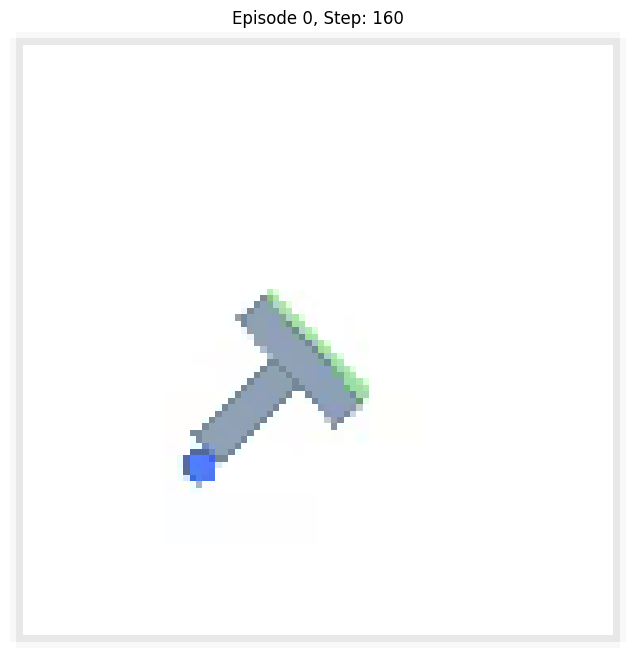

In [11]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Get frames from first episode
episode_index = 0
from_idx = dataset.meta.episodes["dataset_from_index"][episode_index]
to_idx = dataset.meta.episodes["dataset_to_index"][episode_index]

camera_key = dataset.meta.camera_keys[0]
frames = [dataset[idx][camera_key] for idx in range(from_idx, to_idx)] 

plt.figure(figsize=(8, 8))
for frame_idx in range(len(frames)):
    image = frames[frame_idx].permute(1, 2, 0).cpu().numpy()
    clear_output(wait=True)
    plt.clf()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Episode {episode_index}, Step: {frame_idx}')
    display(plt.gcf())
    time.sleep(0.05)
plt.close()


## 3. Initialize SmolVLA Model

Now we'll load the SmolVLA model for training on this task.

In [26]:
# Check for GPU availability
assert torch.cuda.is_available(), "No GPU available. SmolVLA requires CUDA."
device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition


In [6]:
# Set up output directory
output_directory = Path("outputs/train/pusht_smolvla")
output_directory.mkdir(parents=True, exist_ok=True)

In [22]:
# Prepare input/output features for the policy
dataset_metadata = LeRobotDatasetMetadata("lerobot/pusht")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

print("Input features:", list(input_features.keys()))
print("Output features:", list(output_features.keys()))


Input features: ['observation.image', 'observation.state']
Output features: ['action']


In [24]:
from lerobot.policies.smolvla.configuration_smolvla import SmolVLAConfig
# Initialize SmolVLA configuration and policy
# Using pretrained SmolVLA checkpoint

cfg = SmolVLAConfig(
    input_features=input_features,
    output_features=output_features,
    device="cuda",
    pretrained_path="annarborace01/smolvla-test",
    load_vlm_weights=True,
)

print("VLA Config created successfully")

VLA Config created successfully


In [ ]:
# Instantiate the policy
from lerobot.policies.smolvla.modeling_smolvla import SmolVLAPolicy
from lerobot.policies.factory import make_pre_post_processors
policy = SmolVLAPolicy(cfg)
policy.train()
policy.to(device)

# Create pre/post processors
preprocessor, postprocessor = make_pre_post_processors(cfg, dataset_stats=dataset_metadata.stats)

print(f"Policy loaded and moved to {device}")
print(f"Number of trainable parameters: {sum(p.numel() for p in policy.parameters() if p.requires_grad):,}")


Reducing the number of VLM layers to 2 ...
Policy loaded and moved to cuda
Number of trainable parameters: 13,916,512


## 4. Prepare Dataset with Delta Timestamps

SmolVLA uses temporal information, so we need to configure delta timestamps.


In [17]:
# Another policy-dataset interaction is with the delta_timestamps. Each policy expects a given number frames
# which can differ for inputs, outputs and rewards (if there are some).
delta_timestamps = {
    "observation.image": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "observation.state": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}

In [18]:
print("Delta timestamps configuration:")
for key, deltas in delta_timestamps.items():
    print(f"  {key}: {deltas}")


Delta timestamps configuration:
  observation.image: [0.0]
  observation.state: [0.0]
  action: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]


In [19]:
# Load dataset with temporal configuration
dataset = LeRobotDataset(
    "lerobot/pusht",
    delta_timestamps=delta_timestamps,
)

print(f"Dataset loaded with {dataset.num_frames} frames")


Dataset loaded with 25650 frames


## 5. Train SmolVLA Policy

Now we'll train the SmolVLA model on the PushT dataset.


In [20]:
# Training configuration
training_steps =20000
batch_size = 64  # SmolVLA may need smaller batch size due to memory

# Set up optimizer and scheduler
optimizer_config = {
    "lr": 0.0001,
    "weight_decay": 1e-10,
    "betas": (0.9, 0.95),
    "eps": 1e-08
}

scheduler_config = {
    "num_warmup_steps": 1000,
    "num_decay_steps": 30000,
    "peak_lr": 0.0001,
    "decay_lr": 2.5e-06
}

grad_clip_norm = 10.0

# Create AdamW optimizer
optimizer = torch.optim.AdamW(
    policy.parameters(),
    lr=optimizer_config["lr"],
    weight_decay=optimizer_config["weight_decay"],
    betas=optimizer_config["betas"],
    eps=optimizer_config["eps"]
)

# Create cosine decay with warmup scheduler
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_decay_steps, peak_lr, decay_lr):
    """
    Create a learning rate scheduler with linear warmup and cosine decay.
    
    Args:
        optimizer: PyTorch optimizer
        num_warmup_steps: Number of steps for linear warmup
        peak_lr: Peak learning rate after warmup
        num_decay_steps: Total number of steps for cosine decay
        decay_lr: Minimum learning rate at the end of decay
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, num_warmup_steps))
        else:
            # Cosine decay
            progress = float(current_step - num_warmup_steps) / float(max(1, num_decay_steps - num_warmup_steps))
            progress = min(progress, 1.0)
            cosine_decay = 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.14159265359))).item()
            return (decay_lr / peak_lr) + (1.0 - decay_lr / peak_lr) * cosine_decay
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=scheduler_config["num_warmup_steps"],
    num_decay_steps=scheduler_config["num_decay_steps"],
    peak_lr=scheduler_config["peak_lr"],
    decay_lr=scheduler_config["decay_lr"]
)

# Set up dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

print(f"Training configuration:")
print(f"  Steps: {training_steps}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {optimizer_config['lr']}")
print(f"  Weight decay: {optimizer_config['weight_decay']}")
print(f"  Betas: {optimizer_config['betas']}")
print(f"  Epsilon: {optimizer_config['eps']}")
print(f"  Gradient clip norm: {grad_clip_norm}")
print(f"  Warmup steps: {scheduler_config['num_warmup_steps']}")
print(f"  Decay steps: {scheduler_config['num_decay_steps']}")
print(f"  Peak LR: {scheduler_config['peak_lr']}")
print(f"  Decay LR: {scheduler_config['decay_lr']}")
print(f"  Batches per epoch: {len(dataloader)}")


Training configuration:
  Steps: 20000
  Batch size: 64
  Learning rate: 0.0001
  Weight decay: 1e-10
  Betas: (0.9, 0.95)
  Epsilon: 1e-08
  Gradient clip norm: 10.0
  Warmup steps: 1000
  Decay steps: 30000
  Peak LR: 0.0001
  Decay LR: 2.5e-06
  Batches per epoch: 400


## Understanding How LambdaLR Scheduler Works

The `torch.optim.lr_scheduler.LambdaLR` scheduler adjusts the optimizer's learning rate using this formula:

**`new_lr = base_lr × lr_lambda(current_step)`**

Where:
- `base_lr`: The initial learning rate set in the optimizer (stored internally by the scheduler)
- `lr_lambda(current_step)`: A multiplier function that returns a value based on the current step
- `new_lr`: The actual learning rate applied at that step

Let's visualize this relationship!


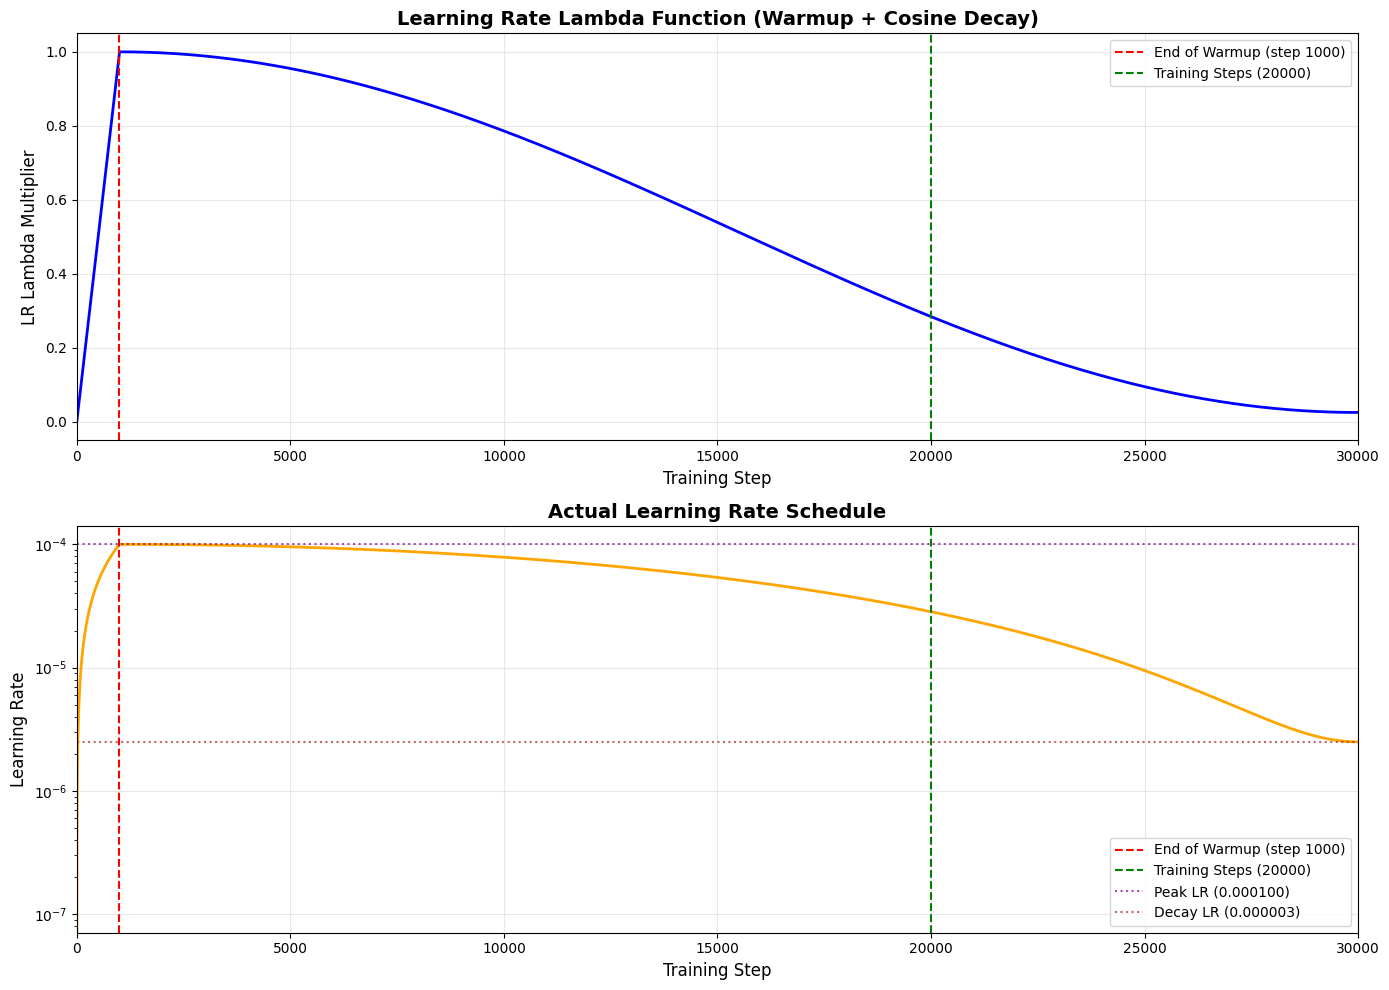


Learning Rate Schedule Summary:
  Warmup Phase: steps 0 -> 1000
  Cosine Decay Phase: steps 1000 -> 30000
  Your Training Steps: 20000
  Peak LR: 0.000100
  Decay LR: 0.000003
  LR at step 20000: 0.000028


In [81]:
# Plot lr_lambda for training steps
import matplotlib.pyplot as plt
import numpy as np

# Create a range of steps to visualize
max_steps_to_plot = max(training_steps, scheduler_config["num_decay_steps"])
steps = np.arange(0, max_steps_to_plot + 1000)

# Get the lr_lambda function from scheduler
lr_lambda_func = scheduler.lr_lambdas[0]

# Calculate lr_lambda values for each step
lr_lambda_values = [lr_lambda_func(step) for step in steps]

# Calculate actual learning rates
actual_lrs = [scheduler_config["peak_lr"] * lr_lambda_func(step) for step in steps]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: lr_lambda multiplier
ax1.plot(steps, lr_lambda_values, linewidth=2, color='blue')
ax1.axvline(x=scheduler_config['num_warmup_steps'], color='red', linestyle='--', 
            linewidth=1.5, label=f'End of Warmup (step {scheduler_config["num_warmup_steps"]})')
ax1.axvline(x=training_steps, color='green', linestyle='--', 
            linewidth=1.5, label=f'Training Steps ({training_steps})')
ax1.set_xlabel('Training Step', fontsize=12)
ax1.set_ylabel('LR Lambda Multiplier', fontsize=12)
ax1.set_title('Learning Rate Lambda Function (Warmup + Cosine Decay)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(0, max_steps_to_plot)

# Plot 2: Actual learning rate
ax2.plot(steps, actual_lrs, linewidth=2, color='orange')
ax2.axvline(x=scheduler_config['num_warmup_steps'], color='red', linestyle='--', 
            linewidth=1.5, label=f'End of Warmup (step {scheduler_config["num_warmup_steps"]})')
ax2.axvline(x=training_steps, color='green', linestyle='--', 
            linewidth=1.5, label=f'Training Steps ({training_steps})')
ax2.axhline(y=scheduler_config['peak_lr'], color='purple', linestyle=':', 
            linewidth=1.5, alpha=0.7, label=f'Peak LR ({scheduler_config["peak_lr"]:.6f})')
ax2.axhline(y=scheduler_config['decay_lr'], color='brown', linestyle=':', 
            linewidth=1.5, alpha=0.7, label=f'Decay LR ({scheduler_config["decay_lr"]:.6f})')
ax2.set_xlabel('Training Step', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Actual Learning Rate Schedule', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(0, max_steps_to_plot)
ax2.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

print(f"\nLearning Rate Schedule Summary:")
print(f"  Warmup Phase: steps 0 -> {scheduler_config['num_warmup_steps']}")
print(f"  Cosine Decay Phase: steps {scheduler_config['num_warmup_steps']} -> {scheduler_config['num_decay_steps']}")
print(f"  Your Training Steps: {training_steps}")
print(f"  Peak LR: {scheduler_config['peak_lr']:.6f}")
print(f"  Decay LR: {scheduler_config['decay_lr']:.6f}")
print(f"  LR at step {training_steps}: {scheduler_config['peak_lr'] * lr_lambda_func(training_steps):.6f}")


In [85]:
# Training loop
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision.io._video_deprecation_warning')

step = 0
done = False
epoch = 0
losses = []
learning_rates = []

print("Starting training...\n")
# Add this right after creating the scheduler in Cell 18
print(f"Initial LR after scheduler creation: {optimizer.param_groups[0]['lr']:.8f}")
print(f"Scheduler last_epoch: {scheduler.last_epoch}")

policy.train()

log_freq = 100

while not done:
    epoch += 1
    for batch in dataloader:
        # Preprocess batch
        batch = preprocessor(batch)
        
        # Forward pass
        loss, _ = policy.forward(batch)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=grad_clip_norm)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        learning_rates.append(current_lr)
        # Track metrics
        if step % log_freq == 0:
            avg_loss = sum(losses[-log_freq:]) / len(losses[-log_freq:])
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}, Step {step:5d}: loss = {loss.item():.4f}, avg_loss = {avg_loss:.4f}, lr = {current_lr:.6f}")
                
        step += 1
        if step >= training_steps:
            done = True
            break

print(f"\nTraining completed! Final loss: {losses[-1]:.4f}")


Starting training...

Initial LR after scheduler creation: 0.00000020
Scheduler last_epoch: 2
Epoch 1, Step     0: loss = 1.5025, avg_loss = 1.5025, lr = 0.000000
Epoch 1, Step    50: loss = 1.1600, avg_loss = 1.3770, lr = 0.000005
Epoch 1, Step   100: loss = 1.0190, avg_loss = 1.0834, lr = 0.000010
Epoch 1, Step   150: loss = 0.7797, avg_loss = 0.9135, lr = 0.000015
Epoch 1, Step   200: loss = 0.4399, avg_loss = 0.5654, lr = 0.000020
Epoch 1, Step   250: loss = 0.2816, avg_loss = 0.3189, lr = 0.000025
Epoch 1, Step   300: loss = 0.1514, avg_loss = 0.2073, lr = 0.000030
Epoch 1, Step   350: loss = 0.1303, avg_loss = 0.1542, lr = 0.000035
Epoch 2, Step   400: loss = 0.0990, avg_loss = 0.1241, lr = 0.000040
Epoch 2, Step   450: loss = 0.1210, avg_loss = 0.1067, lr = 0.000045
Epoch 2, Step   500: loss = 0.0844, avg_loss = 0.0944, lr = 0.000050
Epoch 2, Step   550: loss = 0.0723, avg_loss = 0.0894, lr = 0.000055
Epoch 2, Step   600: loss = 0.0701, avg_loss = 0.0781, lr = 0.000060
Epoch 2, 

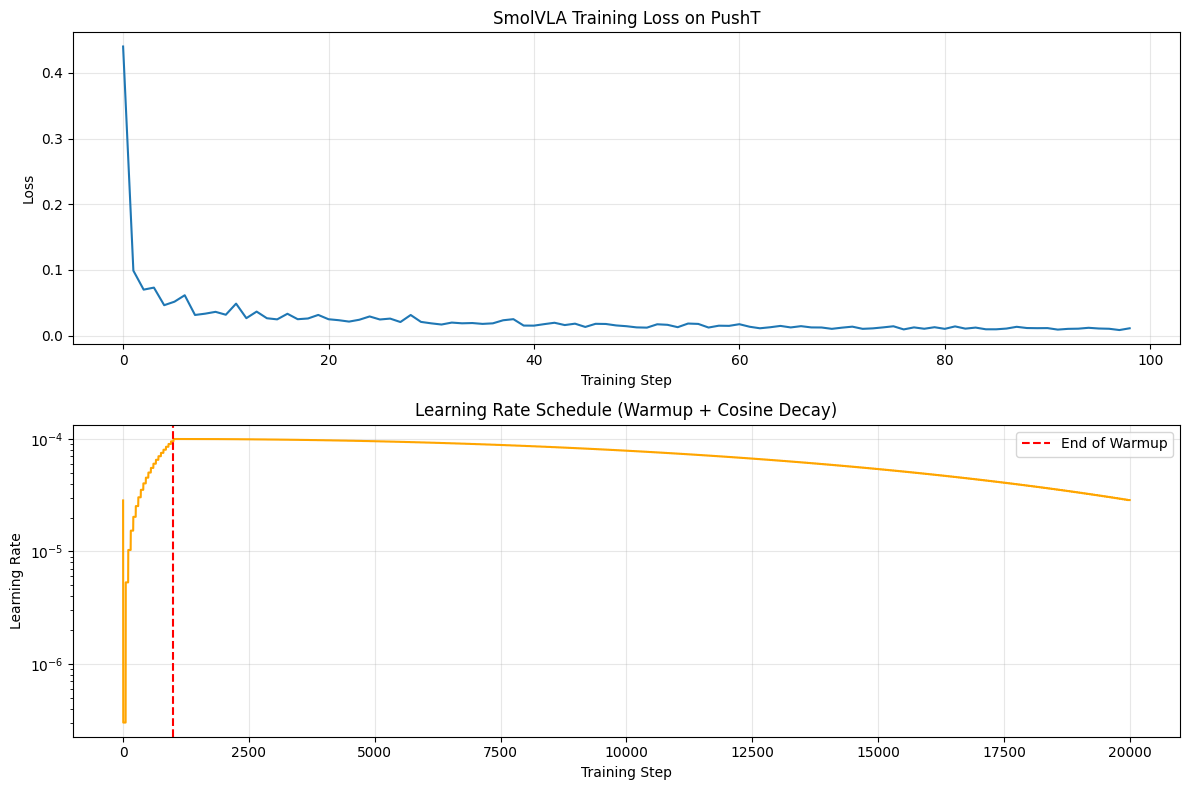

In [88]:
# Plot training loss and learning rate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot loss
ax1.plot(losses[200::200])
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss')
ax1.set_title('SmolVLA Training Loss on PushT')
ax1.grid(True, alpha=0.3)

# Plot learning rate schedule
ax2.plot(learning_rates, color='orange')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule (Warmup + Cosine Decay)')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=scheduler_config['num_warmup_steps'], color='red', linestyle='--', label='End of Warmup')
ax2.set_yscale('log')  # Log scale for better visualization
ax2.legend()

plt.tight_layout()
plt.show()


## 6. Save Trained Model


In [89]:
# Save the trained model
policy.save_pretrained(output_directory)
preprocessor.save_pretrained(output_directory)
postprocessor.save_pretrained(output_directory)

print(f"Model saved to {output_directory}")


Model saved to outputs/train/pusht_smolvla


## 7. Evaluate on PushT Environment

Now let's test the trained SmolVLA model in the PushT environment.


In [97]:
from lerobot.policies.smolvla.modeling_smolvla import SmolVLAPolicy
from lerobot.policies.factory import make_pre_post_processors

model_path = None
if True:
    model_path = "annarborace01/my-smolvla-pusht"
else:
    model_path = output_directory


policy = SmolVLAPolicy.from_pretrained(model_path)
print(f"Number of trainable parameters: {sum(p.numel() for p in policy.parameters() if p.requires_grad):,}")
preprocessor, postprocessor = make_pre_post_processors(policy.config, pretrained_path=model_path)

policy.eval()
policy.to(device)

print(f"Model loaded from {model_path}")
print(f"Policy device: {next(policy.parameters()).device}")


Loading  HuggingFaceTB/SmolVLM2-500M-Video-Instruct weights ...
Reducing the number of VLM layers to 16 ...
Number of trainable parameters: 99,880,992
Model loaded from annarborace01/my-smolvla-pusht
Policy device: cuda:0


In [28]:
# Create PushT environment
import gymnasium as gym
import numpy as np
from pathlib import Path

try:
    import gym_pusht
    env = gym.make("gym_pusht/PushT-v0", render_mode="rgb_array", obs_type="pixels_agent_pos")
    print("PushT environment created successfully")
except ImportError:
    print("Warning: gym_pusht not installed. Install with: pip install gym-pusht")
    env = None
except Exception as e:
    print(f"Error creating environment: {e}")
    env = None


PushT environment created successfully


In [98]:
import torch

# Check for GPU availability
assert torch.cuda.is_available(), "No GPU available. SmolVLA requires CUDA."
device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# Reset the environment
observation, info = env.reset(seed=420)
# Reset the policy's internal queue at the start of each episode
policy.reset()

frames_for_video = []
max_steps = 1000
log_freq = 50
episode_reward = 0
for step in range(max_steps):
    # Get current observation
    current_image = torch.from_numpy(observation["pixels"]).float() / 255.0
    frames_for_video.append(current_image)
    # Normalize image from [0, 255] to [0, 1] and permute to (C, H, W) for torch input
    current_image = current_image.permute(2, 0, 1)
    current_state = torch.from_numpy(observation["agent_pos"]).float()

    # Build observation dict for policy (single timestep, no temporal stacking)
    # The policy's queue mechanism will handle the temporal dimension
    # Shape: [batch, channels, height, width] for images, [batch, state_dim] for state

    # Check input features
    # print(input_features.keys())
    batch = {
        "observation.image": current_image.unsqueeze(0).to(device),  # [1, C, H, W]
        "observation.state": current_state.unsqueeze(0).to(device),  # [1, state_dim]
        "task": "Push the T-shaped block onto the T-shaped target."
    }

    # Get action from policy
    actions = None
    with torch.no_grad():
        batch = preprocessor(batch)
        actions = policy.select_action(batch)
        actions = postprocessor(actions)
        # Execute action in environment
    assert actions is not None
    action = actions[0].cpu().numpy()
    observation, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    success = info.get("success", False)
    if step % log_freq == 0:
        print(f"Reward = {episode_reward:.2f}, Success = {success}, Steps = {step + 1}")
    if success:
        print(f"Reward = {episode_reward:.2f}, Success = {success}, Steps = {step + 1}")
        break
    if terminated or truncated:
        break
 
    # Execute action in environment

Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
Reward = 0.00, Success = False, Steps = 1
Reward = 0.00, Success = False, Steps = 51
Reward = 0.00, Success = False, Steps = 101
Reward = 1.09, Success = False, Steps = 151
Reward = 13.29, Success = False, Steps = 201
Reward = 35.75, Success = False, Steps = 251


## 8. Compute Loss on All Training Samples

Now we'll run the loaded model on all training samples to compute the loss.


In [100]:
# Compute loss on all training samples
import torch
from tqdm.notebook import tqdm

# Ensure policy is in eval mode
policy.eval()
policy.to(device)

# Create dataloader for the entire training dataset
eval_batch_size = 64
eval_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=eval_batch_size,
    shuffle=False,  # Don't shuffle for consistent evaluation
    pin_memory=True,
    drop_last=False,  # Include all samples
)

print(f"Evaluating on {len(dataset)} training samples...")
print(f"Total batches: {len(eval_dataloader)}")

# Collect losses
all_losses = []
total_samples = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc="Computing losses")):
        # Preprocess batch
        batch = preprocessor(batch)
        
        # Forward pass
        loss, _ = policy.forward(batch)
        
        # Store loss
        batch_size = batch["observation.image"].size(0)
        all_losses.append(loss.item() * batch_size)  # Weighted by batch size
        total_samples += batch_size
        
        if (batch_idx + 1) % 50 == 0:
            current_avg_loss = sum(all_losses) / total_samples
            print(f"  Batch {batch_idx + 1}/{len(eval_dataloader)}: avg_loss = {current_avg_loss:.6f}")

# Compute final statistics
total_loss = sum(all_losses)
avg_loss = total_loss / total_samples

print(f"\n{'='*60}")
print(f"Evaluation Results on Training Set:")
print(f"{'='*60}")
print(f"Total samples: {total_samples}")
print(f"Total batches: {len(eval_dataloader)}")
print(f"Average loss: {avg_loss:.6f}")
print(f"Total loss: {total_loss:.6f}")
print(f"{'='*60}")


Evaluating on 25650 training samples...
Total batches: 401


Computing losses:   0%|          | 0/401 [00:00<?, ?it/s]

  Batch 50/401: avg_loss = 0.005444
  Batch 100/401: avg_loss = 0.005295
  Batch 150/401: avg_loss = 0.005287
  Batch 200/401: avg_loss = 0.005415
  Batch 250/401: avg_loss = 0.005475
  Batch 300/401: avg_loss = 0.005530
  Batch 350/401: avg_loss = 0.005556
  Batch 400/401: avg_loss = 0.005579

Evaluation Results on Training Set:
Total samples: 25650
Total batches: 401
Average loss: 0.005586
Total loss: 143.290123


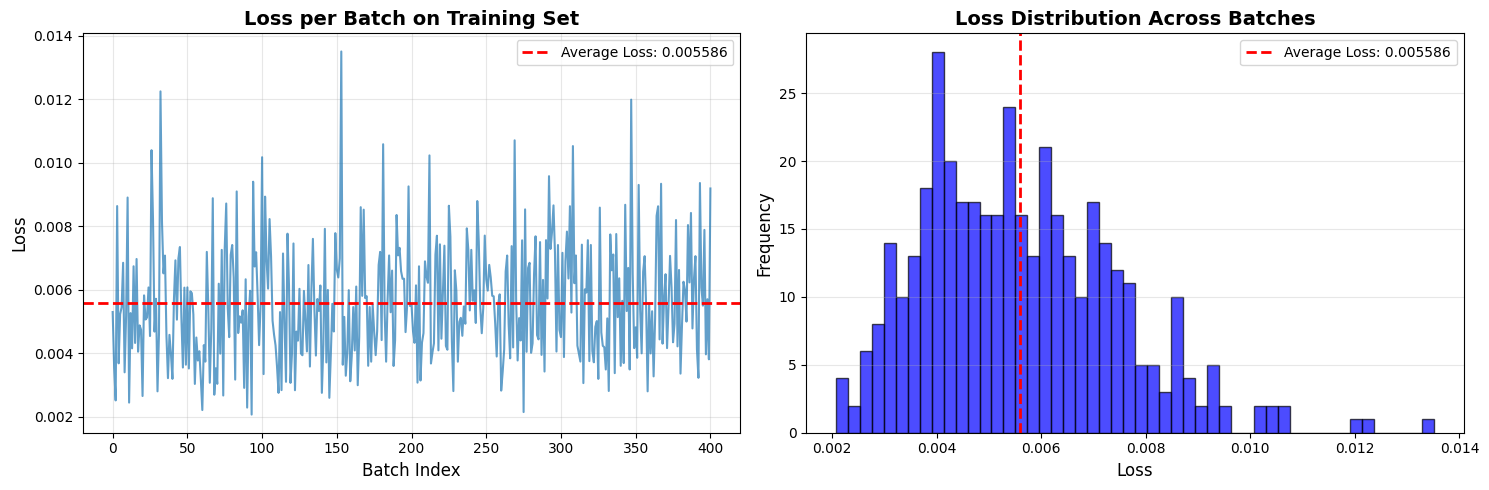


Loss Statistics:
  Min loss: 0.002076
  Max loss: 0.013510
  Median loss: 0.005412
  Std deviation: 0.001873


In [101]:
# Visualize loss distribution across batches
import matplotlib.pyplot as plt
import numpy as np

# Convert weighted losses back to per-batch averages for visualization
batch_avg_losses = []
sample_count = 0
for i, weighted_loss in enumerate(all_losses):
    if i < len(all_losses) - 1:
        batch_avg_losses.append(weighted_loss / eval_batch_size)
    else:
        # Last batch might have fewer samples
        remaining_samples = total_samples - sample_count
        batch_avg_losses.append(weighted_loss / remaining_samples)
    sample_count += eval_batch_size if i < len(all_losses) - 1 else remaining_samples

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss per batch
ax1.plot(batch_avg_losses, linewidth=1.5, alpha=0.7)
ax1.axhline(y=avg_loss, color='red', linestyle='--', linewidth=2, label=f'Average Loss: {avg_loss:.6f}')
ax1.set_xlabel('Batch Index', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss per Batch on Training Set', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Loss histogram
ax2.hist(batch_avg_losses, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax2.axvline(x=avg_loss, color='red', linestyle='--', linewidth=2, label=f'Average Loss: {avg_loss:.6f}')
ax2.set_xlabel('Loss', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Loss Distribution Across Batches', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\nLoss Statistics:")
print(f"  Min loss: {min(batch_avg_losses):.6f}")
print(f"  Max loss: {max(batch_avg_losses):.6f}")
print(f"  Median loss: {np.median(batch_avg_losses):.6f}")
print(f"  Std deviation: {np.std(batch_avg_losses):.6f}")


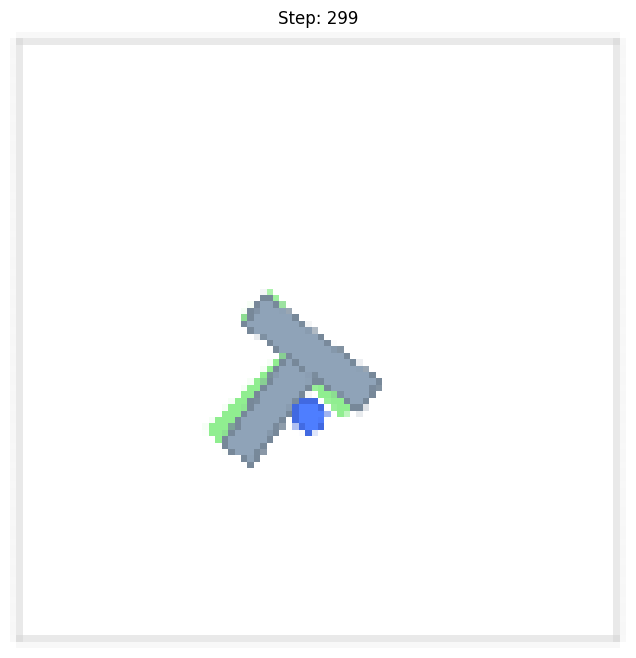

<Figure size 800x800 with 0 Axes>

In [102]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

print("Visualizing first episode...")
plt.figure(figsize=(8, 8))
for frame_idx in range(0, len(frames_for_video)):
    image = frames_for_video[frame_idx]
    # Display every frame slowly
    clear_output(wait=True)
    plt.clf()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Step: {frame_idx}')
    display(plt.gcf())
    # Add delay to slow down the rendering (adjust this value as needed)
    time.sleep(0.01)  # 0.1 seconds = 10 FPS, increase for slower rendering
plt.clf()
env.close()

## 9. Mess things around

In [32]:
from lerobot.policies.smolvla.configuration_smolvla import SmolVLAConfig

cfg = SmolVLAConfig(
    input_features=input_features,
    output_features=output_features,
    device="cuda",
    pretrained_path="annarborace01/smolvla-test",
    load_vlm_weights=False,
    num_vlm_layers=2,
    chunk_size = 10,
    n_action_steps = 5,
    add_image_special_tokens=False,
)

# Create pre/post processors
preprocessor, postprocessor = make_pre_post_processors(cfg, dataset_stats=dataset_metadata.stats)

# Another policy-dataset interaction is with the delta_timestamps. Each policy expects a given number frames
# which can differ for inputs, outputs and rewards (if there are some).
delta_timestamps = {
    "observation.image": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "observation.state": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}
# Load dataset with temporal configuration
dataset = LeRobotDataset(
    "lerobot/pusht",
    delta_timestamps=delta_timestamps,
)

print(f"Dataset loaded with {dataset.num_frames} frames")

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=2,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
)

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision.io._video_deprecation_warning')

example_data = next(iter(dataloader))
for key, value in example_data.items():
    print(key, value.shape if isinstance(value, torch.Tensor) else value)


batch = preprocessor(example_data)

Dataset loaded with 25650 frames
observation.image torch.Size([2, 3, 96, 96])
observation.state torch.Size([2, 1, 2])
action torch.Size([2, 10, 2])
episode_index torch.Size([2])
frame_index torch.Size([2])
timestamp torch.Size([2])
next.reward torch.Size([2])
next.done torch.Size([2])
next.success torch.Size([2])
index torch.Size([2])
task_index torch.Size([2])
observation.image_is_pad torch.Size([2, 1])
observation.state_is_pad torch.Size([2, 1])
action_is_pad torch.Size([2, 10])
task ['Push the T-shaped block onto the T-shaped target.', 'Push the T-shaped block onto the T-shaped target.']


In [33]:
for key, value in batch.items():
    print(key, value.shape if isinstance(value, torch.Tensor) else value)

# tokenizer_max_length default is 8.
print(batch["observation.language.tokens"][0])
print(batch["observation.language.attention_mask"][0])

action torch.Size([2, 10, 2])
next.reward torch.Size([2])
next.done torch.Size([2])
next.truncated False
info {}
observation.image_is_pad torch.Size([2, 1])
observation.state_is_pad torch.Size([2, 1])
action_is_pad torch.Size([2, 10])
task ['Push the T-shaped block onto the T-shaped target.\n', 'Push the T-shaped block onto the T-shaped target.\n']
index torch.Size([2])
task_index torch.Size([2])
observation.image torch.Size([2, 3, 96, 96])
observation.state torch.Size([2, 1, 2])
observation.language.tokens torch.Size([2, 14])
observation.language.attention_mask torch.Size([2, 14])
tensor([37910,   260,   312,    29, 10498,  3608,  4581,   260,   312,    29,
        10498,  2370,    30,   198], device='cuda:0')
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True], device='cuda:0')


In [37]:
import logging

logging.basicConfig(
    format='%(filename)s:%(lineno)d - %(levelname)s - %(message)s',
    level=logging.INFO
)

logging.info("YWH")  # Will automatically show filename and line number

In [42]:
from lerobot.policies.smolvla import modeling_smolvla
import importlib

# Reload the module
importlib.reload(modeling_smolvla)

from lerobot.policies.smolvla.modeling_smolvla import SmolVLAPolicy
cfg.debug_mode = True
policy = SmolVLAPolicy(cfg)
policy.train()
policy.to(device)
loss, _ = policy.forward(batch)

Reducing the number of VLM layers to 2 ...
images.shape 1 torch.Size([2, 3, 512, 512])
img_masks.shape 1 torch.Size([2])
observation.language.tokens
lang_tokens.shape torch.Size([2, 14])
observation.language.attention_mask
lang_masks.shape torch.Size([2, 14])
batch[ACTION].shape torch.Size([2, 10, 2])
actions.shape torch.Size([2, 10, 32])
noise.shape torch.Size([2, 10, 32])
actions.shape torch.Size([2, 10, 32])
time.shape torch.Size([2])
time_expanded.shape torch.Size([2, 1, 1])
x_t.shape torch.Size([2, 10, 32])
velocity.shape torch.Size([2, 10, 32])
lang_emb.shape torch.Size([2, 14, 960])
state_emb.shape torch.Size([2, 960])
prefix_embs.shape torch.Size([2, 79, 960])
prefix_pad_masks.shape torch.Size([2, 79])
prefix_att_masks.shape torch.Size([2, 79])
suffix_embs.shape torch.Size([2, 10, 720])
suffix_pad_masks.shape torch.Size([2, 10])
suffix_att_masks.shape torch.Size([2, 10])
pad_masks.shape torch.Size([2, 89])
att_masks.shape torch.Size([2, 89])
att_2d_masks.shape torch.Size([2, 89

In [34]:
actions = policy.select_action(batch)
print("actions.shape: ", actions.shape)

actions.shape:  torch.Size([2, 2])


### attention 2d masks

- Row i = Query (token trying to attend)
- Column j = Key (token being attended to)
- result[i, j] = True means token i can attend to token j

```
# result[i, j] = left[0, 0, j] <= right[0, i, 0]
#              = cumsum[j] <= cumsum[i]
```

In [ ]:
import torch
mask = torch.tensor([[0, 0, 1, 1, 0, 1]])
cumsum = torch.cumsum(mask, dim=-1)
print(cumsum)
N = cumsum.shape[-1]

left = cumsum[:, None, :]       # Shape: [1, 1, N]
print("left.shape: ", left.shape)
# Right side: cumsum[:, :, None]
right = cumsum[:, :, None]      # Shape: [1, N, 1]
print("right.shape: ", right.shape)
att_2d_masks = left <= right

print(att_2d_masks)
print("-----------------")

left_repeat = left.repeat(1, N, 1)
print("left_repeat.shape: ", left_repeat.shape)

right_repeat = right.repeat(1, 1, N)
print("right_repeat.shape: ", right_repeat.shape)

print("left_repeat: ", left_repeat)
print("right_repeat: ", right_repeat)

att_2d_masks_repeat = left_repeat <= right_repeat
print(att_2d_masks_repeat)


tensor([[0, 0, 1, 2, 2, 3]])
left.shape:  torch.Size([1, 1, 6])
right.shape:  torch.Size([1, 6, 1])
tensor([[[ True,  True, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True]]])
-----------------
left_repeat.shape:  torch.Size([1, 6, 6])
right_repeat.shape:  torch.Size([1, 6, 6])
left_repeat:  tensor([[[0, 0, 1, 2, 2, 3],
         [0, 0, 1, 2, 2, 3],
         [0, 0, 1, 2, 2, 3],
         [0, 0, 1, 2, 2, 3],
         [0, 0, 1, 2, 2, 3],
         [0, 0, 1, 2, 2, 3]]])
right_repeat:  tensor([[[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3, 3]]])
tensor([[[ True,  True, False, False, False, False],
         [ True,  True, False, False, False